# **Github**

In [67]:
from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
personal_token = user_secrets.get_secret("GITHUB_PAT")

In [68]:
!git clone https://{personal_token}@github.com/Mohamed-Mohamed-Ibrahim/NLP-lab-2.git /kaggle/working/NLP-lab-2

fatal: destination path '/kaggle/working/NLP-lab-2' already exists and is not an empty directory.


In [69]:
%cd /kaggle/working/NLP-lab-2

/kaggle/working/NLP-lab-2


In [70]:
!git checkout word2vec

Already on 'word2vec'
Your branch is up to date with 'origin/word2vec'.


# **Import Libraries**

In [71]:
# === Standard Library ===
import os
import warnings
from collections import Counter

# === Third-Party Libraries ===
import pickle
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from datasets import load_dataset
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity

# === PyTorch ===
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau

# **Ignore Warnings**

In [72]:
warnings.filterwarnings('ignore')

# **Load Dataset**

In [73]:
import string

def load_corpus():
    translator = str.maketrans('', '', string.punctuation)
    
    all_sentences = []
    dataset = load_dataset('lhoestq/conll2003')

    for split in ['train', 'validation', 'test']:
        for example in dataset[split]:
            cleaned_tokens = []
            for token in example['tokens']:
                token = token.lower().translate(translator)
                if token != '':  
                    cleaned_tokens.append(token)
            all_sentences.append(cleaned_tokens)

    return all_sentences

In [74]:
corpus = load_corpus()

# **Define Parameters**

In [75]:
# === Hyperparameters ===
embed_dim = 100
context_size = 5
num_negative_samples = 5
lr = 3e-3
num_epochs = 100

# === Device Setup ===
device = "cuda" if torch.cuda.is_available() else "cpu"

# **Define Mapping of Word to Index Function**

In [76]:
from collections import Counter

def build_vocab_mapping(corpus, min_count = 0):
    
    word_counts = Counter()
    for sentence in corpus:
        word_counts.update(sentence)
    
    vocab = [word for word, count in word_counts.items() if count >= min_count]
    
    word_to_idx = {word: idx for idx, word in enumerate(vocab)}
    idx_to_word = {idx: word for idx, word in enumerate(vocab)}

    word_freqs = [word_counts[word] for word in vocab]
    
    return word_to_idx, idx_to_word, word_freqs, len(vocab)

In [77]:
word_to_idx, idx_to_word, word_freqs, vocab_size = build_vocab_mapping(corpus)

# **Define Function That Generate Negative Samples**

In [78]:
import numpy as np, torch, random

def get_unigram_distribution(corpus, word_freqs, word_to_idx, t = 1e-5, power = 0.75):
    word_freqs, total_words = np.array(word_freqs), sum(word_freqs)
    frac_freqs = word_freqs / total_words
    keep_prob = np.minimum((np.sqrt(frac_freqs / t) + 1) * (t / frac_freqs), 1.0)

    indexed_corpus, discarded = [], 0
    for s in corpus:
        idx_s = [word_to_idx[w] for w in s if w in word_to_idx and random.random() < keep_prob[word_to_idx[w]]]
        discarded += len(s) - len(idx_s)
        if idx_s: indexed_corpus.append(idx_s)

    distribution = (word_freqs ** power) / np.sum(word_freqs ** power)
    return indexed_corpus, torch.tensor(distribution, dtype=torch.float)

In [79]:
indexed_corpus, noise_distribution = get_unigram_distribution(corpus, word_freqs, word_to_idx)

# **Define Method That Generate Data**

In [80]:
def generate_training_data(indexed_corpus, context_size):
    data = []
    for sentence in indexed_corpus:
        for i in range(len(sentence)):
            current_window = random.randint(1, context_size)

            context_words =  [sentence[i - j - 1] for j in range(current_window) if i - j - 1 >= 0]
            context_words += [sentence[i + j + 1] for j in range(current_window) if i + j + 1 < len(sentence)]

            for context_word in context_words:
                data.append((sentence[i], context_word))

    return data

In [81]:
train_data = generate_training_data(indexed_corpus, context_size)

# **Define Custom Dataset**

In [82]:
class Word2VecDataset(Dataset):
    def __init__(self, data):
        self.center_words  = torch.tensor([pair[0] for pair in data], dtype = torch.long)
        self.context_words = torch.tensor([pair[1] for pair in data], dtype = torch.long)

    def __len__(self):
        return len(self.center_words)

    def __getitem__(self, idx):
        return self.center_words[idx], self.context_words[idx]

# **Generate Dataset & Dataloader**

In [83]:
# generate dataset
train_dataset = Word2VecDataset(train_data)

# generate dataloader
train_loader = DataLoader(train_dataset, batch_size = 128, shuffle = True)

In [84]:
def get_negative_samples(batch_size, noise_distribution, num_negative_samples, device = 'cuda'):
    # Sample from the noise distribution
    negative_samples = torch.multinomial(noise_distribution, num_negative_samples * batch_size, replacement = True)
    
    # Reshape to (batch_size, num_negative_samples)
    return negative_samples.view(batch_size, num_negative_samples).to(device)

In [85]:
# import numpy as np
# import torch

# def get_unigram_distribution(corpus, word_to_idx):
#     """
#     Converts a corpus of tokenized sentences into indexed_corpus using word_to_idx.
#     Keeps all words (no subsampling or frequency filtering).
#     Returns the full indexed_corpus and None for distribution (since not used).
#     """
#     indexed_corpus = []
#     for s in corpus:
#         idx_s = [word_to_idx[w] for w in s if w in word_to_idx]
#         if idx_s:
#             indexed_corpus.append(idx_s)
#     return indexed_corpus, None

# indexed_corpus, noise_distribution = get_unigram_distribution(corpus, word_to_idx)

# def get_negative_samples(batch_size, vocab_size, num_negative_samples, device='cuda'):
#     """
#     Generates random negative samples uniformly from the vocabulary.
#     """
#     negative_samples = torch.randint(
#         low=0,
#         high=vocab_size,
#         size=(batch_size, num_negative_samples),
#         device=device
#     )
#     return negative_samples

# **Define Model Architecture**

In [86]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SkipGramNegSampling(nn.Module):
    def __init__(self, vocab_size, embed_dim):
        super(SkipGramNegSampling, self).__init__()
        self.embed_dim = embed_dim

        self.embeddings = nn.Embedding(vocab_size, embed_dim, sparse = True)
        self.context_embeddings = nn.Embedding(vocab_size, embed_dim, sparse = True)
        self.log_sigmoid = nn.LogSigmoid()
        
        self.init_embeddings()

    def init_embeddings(self):
        init_range = 0.5 / self.embed_dim
        self.embeddings.weight.data.uniform_(-init_range, init_range)
        self.context_embeddings.weight.data.uniform_(-init_range, init_range)

    def forward(self, target, context, negative_samples):
        target_embedding = self.embeddings(target)
        context_embedding = self.context_embeddings(context)
        negative_embeddings = self.context_embeddings(negative_samples)

        positive_score = self.log_sigmoid(torch.sum((target_embedding * context_embedding), dim = 1))
        negative_score = torch.sum(self.log_sigmoid(-torch.bmm(negative_embeddings, target_embedding.unsqueeze(2)).squeeze(2)), dim = 1) 

        total_score = -torch.mean(positive_score + negative_score)
        return total_score

In [87]:
import torch.optim.lr_scheduler as lr_scheduler
# NOTE: 'current_step', 'num_epochs', 'train_loader', 'lr', 'MIN_ALPHA' must be defined before this block.
# Assuming MIN_ALPHA = 0.0001 is defined globally or locally prior to this block.

MIN_ALPHA = 0.0001
START_ALPHA = lr 
TOTAL_STEPS = len(train_loader) * num_epochs 
current_step = 0 # Initialize current step count

# 1. Initialize Model and Optimizer using START_ALPHA
model = SkipGramNegSampling(vocab_size, embed_dim).to(device)
optimizer = optim.SparseAdam(model.parameters(), lr=START_ALPHA)

# 2. Define the decay function
def lambda_decay(step):
    progress = min(step, TOTAL_STEPS) / TOTAL_STEPS
    decay_factor = max(MIN_ALPHA / START_ALPHA, 1.0 - progress)
    return decay_factor

# 3. Initialize the scheduler
scheduler = lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda_decay)


best_loss = float('inf')
patience_counter = 0

training_losses = []

for epoch in range(1, num_epochs + 1):
    model.train(); total_train_loss = 0;
    
    for target, context in tqdm(train_loader):
        target, context = target.long().to(device), context.long().to(device)
        negative_samples = get_negative_samples(target.size(0), noise_distribution, num_negative_samples, device)
        
        optimizer.zero_grad()
        loss = model(target, context, negative_samples)
        loss.backward()
        
        optimizer.step()
        
        # --- LR DECAY FIX ADDED HERE ---
        current_step += 1
        scheduler.step()
        # --- END FIX ---

        total_train_loss += loss.item()
    
    avg_train_loss = total_train_loss / len(train_loader); training_losses.append(avg_train_loss)
    
    # Get the current LR for display (it was updated in the inner loop)
    current_lr = optimizer.param_groups[0]['lr'] 
    print(f"Epoch: {epoch} | Training Loss: {avg_train_loss:.4f} | Final LR: {current_lr:.6f}")
    
    if avg_train_loss + 0.01 < best_loss:
        best_loss, patience_counter = avg_train_loss, 0
        torch.save(model.state_dict(), 'best_model.pth')
        print("New best model saved.")
    
    else:
        patience_counter += 1
        if patience_counter > 3:
            print(f"Stop at Epoch {epoch}"); break;

100%|██████████| 2543/2543 [00:13<00:00, 190.83it/s]


Epoch: 1 | Training Loss: 3.2328 | Final LR: 0.002970
New best model saved.


100%|██████████| 2543/2543 [00:13<00:00, 188.59it/s]


Epoch: 2 | Training Loss: 2.6113 | Final LR: 0.002940
New best model saved.


100%|██████████| 2543/2543 [00:13<00:00, 191.60it/s]


Epoch: 3 | Training Loss: 2.3086 | Final LR: 0.002910
New best model saved.


100%|██████████| 2543/2543 [00:13<00:00, 191.49it/s]


Epoch: 4 | Training Loss: 1.8885 | Final LR: 0.002880
New best model saved.


100%|██████████| 2543/2543 [00:13<00:00, 188.89it/s]


Epoch: 5 | Training Loss: 1.4772 | Final LR: 0.002850
New best model saved.


100%|██████████| 2543/2543 [00:13<00:00, 187.69it/s]


Epoch: 6 | Training Loss: 1.1469 | Final LR: 0.002820
New best model saved.


100%|██████████| 2543/2543 [00:13<00:00, 191.19it/s]


Epoch: 7 | Training Loss: 0.9061 | Final LR: 0.002790
New best model saved.


100%|██████████| 2543/2543 [00:13<00:00, 189.77it/s]


Epoch: 8 | Training Loss: 0.7335 | Final LR: 0.002760
New best model saved.


100%|██████████| 2543/2543 [00:13<00:00, 192.62it/s]


Epoch: 9 | Training Loss: 0.6122 | Final LR: 0.002730
New best model saved.


100%|██████████| 2543/2543 [00:13<00:00, 193.43it/s]


Epoch: 10 | Training Loss: 0.5253 | Final LR: 0.002700
New best model saved.


100%|██████████| 2543/2543 [00:13<00:00, 187.94it/s]


Epoch: 11 | Training Loss: 0.4590 | Final LR: 0.002670
New best model saved.


100%|██████████| 2543/2543 [00:13<00:00, 184.77it/s]


Epoch: 12 | Training Loss: 0.4105 | Final LR: 0.002640
New best model saved.


100%|██████████| 2543/2543 [00:13<00:00, 189.41it/s]


Epoch: 13 | Training Loss: 0.3741 | Final LR: 0.002610
New best model saved.


100%|██████████| 2543/2543 [00:13<00:00, 190.91it/s]


Epoch: 14 | Training Loss: 0.3432 | Final LR: 0.002580
New best model saved.


100%|██████████| 2543/2543 [00:13<00:00, 188.56it/s]


Epoch: 15 | Training Loss: 0.3203 | Final LR: 0.002550
New best model saved.


100%|██████████| 2543/2543 [00:13<00:00, 187.98it/s]


Epoch: 16 | Training Loss: 0.3028 | Final LR: 0.002520
New best model saved.


100%|██████████| 2543/2543 [00:13<00:00, 186.78it/s]


Epoch: 17 | Training Loss: 0.2853 | Final LR: 0.002490
New best model saved.


100%|██████████| 2543/2543 [00:13<00:00, 193.44it/s]


Epoch: 18 | Training Loss: 0.2726 | Final LR: 0.002460
New best model saved.


100%|██████████| 2543/2543 [00:13<00:00, 191.58it/s]


Epoch: 19 | Training Loss: 0.2619 | Final LR: 0.002430
New best model saved.


100%|██████████| 2543/2543 [00:13<00:00, 193.03it/s]


Epoch: 20 | Training Loss: 0.2519 | Final LR: 0.002400
New best model saved.


100%|██████████| 2543/2543 [00:13<00:00, 191.21it/s]


Epoch: 21 | Training Loss: 0.2428 | Final LR: 0.002370


100%|██████████| 2543/2543 [00:13<00:00, 189.14it/s]


Epoch: 22 | Training Loss: 0.2350 | Final LR: 0.002340
New best model saved.


100%|██████████| 2543/2543 [00:13<00:00, 191.10it/s]


Epoch: 23 | Training Loss: 0.2317 | Final LR: 0.002310


100%|██████████| 2543/2543 [00:13<00:00, 189.73it/s]


Epoch: 24 | Training Loss: 0.2225 | Final LR: 0.002280
New best model saved.


100%|██████████| 2543/2543 [00:13<00:00, 190.07it/s]


Epoch: 25 | Training Loss: 0.2202 | Final LR: 0.002250


100%|██████████| 2543/2543 [00:13<00:00, 187.43it/s]


Epoch: 26 | Training Loss: 0.2142 | Final LR: 0.002220


100%|██████████| 2543/2543 [00:13<00:00, 190.26it/s]


Epoch: 27 | Training Loss: 0.2102 | Final LR: 0.002190
New best model saved.


100%|██████████| 2543/2543 [00:13<00:00, 191.29it/s]


Epoch: 28 | Training Loss: 0.2054 | Final LR: 0.002160


100%|██████████| 2543/2543 [00:13<00:00, 186.42it/s]


Epoch: 29 | Training Loss: 0.2030 | Final LR: 0.002130


100%|██████████| 2543/2543 [00:13<00:00, 186.18it/s]


Epoch: 30 | Training Loss: 0.1990 | Final LR: 0.002100
New best model saved.


100%|██████████| 2543/2543 [00:13<00:00, 187.99it/s]


Epoch: 31 | Training Loss: 0.1968 | Final LR: 0.002070


100%|██████████| 2543/2543 [00:13<00:00, 187.94it/s]


Epoch: 32 | Training Loss: 0.1928 | Final LR: 0.002040


100%|██████████| 2543/2543 [00:13<00:00, 189.28it/s]


Epoch: 33 | Training Loss: 0.1906 | Final LR: 0.002010


100%|██████████| 2543/2543 [00:13<00:00, 188.59it/s]


Epoch: 34 | Training Loss: 0.1885 | Final LR: 0.001980
New best model saved.


100%|██████████| 2543/2543 [00:13<00:00, 191.09it/s]


Epoch: 35 | Training Loss: 0.1860 | Final LR: 0.001950


100%|██████████| 2543/2543 [00:13<00:00, 189.21it/s]


Epoch: 36 | Training Loss: 0.1821 | Final LR: 0.001920


100%|██████████| 2543/2543 [00:13<00:00, 195.57it/s]


Epoch: 37 | Training Loss: 0.1816 | Final LR: 0.001890


100%|██████████| 2543/2543 [00:13<00:00, 194.98it/s]

Epoch: 38 | Training Loss: 0.1800 | Final LR: 0.001860
Stop at Epoch 38


# **Load The Best Model**

In [88]:
best_model = SkipGramNegSampling(vocab_size, embed_dim)
best_model.load_state_dict(torch.load('best_model.pth') )
best_model.to(device) 

SkipGramNegSampling(
  (embeddings): Embedding(25528, 100, sparse=True)
  (context_embeddings): Embedding(25528, 100, sparse=True)
  (log_sigmoid): LogSigmoid()
)

# **Plot Train and Validation Losses and Learning rates**

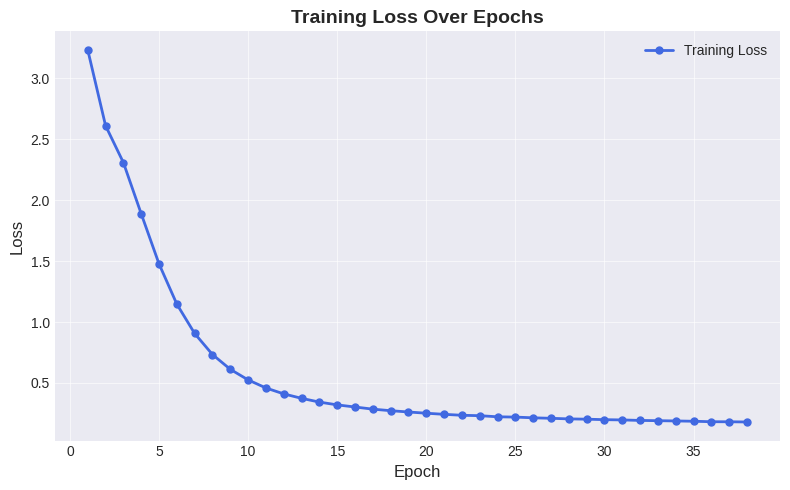

In [89]:
epochs = range(1, len(training_losses) + 1)
plt.style.use("seaborn-v0_8-darkgrid")

plt.figure(figsize=(8, 5))
plt.plot(epochs, training_losses, 'o-', color='royalblue', lw=2, markersize=5, label='Training Loss')

plt.title('Training Loss Over Epochs', fontsize=14, weight='bold')
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.legend()
plt.grid(alpha=0.6)
plt.tight_layout()

plt.savefig('training_loss.png', dpi=300)
plt.show()

# **Save Embeddings and Word to Index Dictionary**

In [90]:
embeddings = model.embeddings.weight.detach()
torch.save(embeddings, "embeddings.pt")

with open("word_to_idx.pkl", "wb") as f:
    pickle.dump(word_to_idx, f)

print("✅ Embeddings and word_to_idx saved successfully!")

✅ Embeddings and word_to_idx saved successfully!


# **Load Embeddings and Word to Index Dictionary**

In [91]:
embeddings = torch.load("embeddings.pt")

with open("word_to_idx.pkl", "rb") as f:
    word_to_idx = pickle.load(f)

print("✅ Embeddings and word_to_idx loaded successfully!")

✅ Embeddings and word_to_idx loaded successfully!


# **Visual Word Analogy**

In [92]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from matplotlib.lines import Line2D
from matplotlib.patches import FancyArrowPatch

def plot_target_based_analogy(embeddings, word_to_idx, words, save_path):
    """
    Plots an analogy using a "Target-Based" projection.
    The X-axis IS the target vector's direction.
    The Y-axis IS the error/perpendicular direction.
    This method *guarantees* that a Cosine Similarity of 1.0
    will show a perfect overlap.
    """
    missing = [w for w in words if w not in word_to_idx]
    if missing:
        print(f"Skipping '{save_path}': missing {missing}")
        return

    # 1. Get the high-dimensional vectors
    A, B, C, D = [embeddings[word_to_idx[w]] for w in words]
    result_vec = (B - A + C)
    target_vec = D
    
    # 2. Calculate metrics in high-D space
    # (Move to numpy for scikit-learn and linalg)
    result_np = result_vec.cpu().numpy()
    target_np = target_vec.cpu().numpy()
    
    cosine_sim = cosine_similarity([result_np], [target_np])[0, 0]
    euclidean_dist = np.linalg.norm(result_np - target_np)

    # 3. Create the new 2D axes
    # X-axis is the normalized target vector
    x_axis_vec = target_np / (np.linalg.norm(target_np) + 1e-9)
    
    # Y-axis is the part of the result_vec that is *perpendicular* to the x_axis_vec
    # This is the "error" vector
    y_component = result_np - (np.dot(result_np, x_axis_vec) * x_axis_vec)
    
    # Check if the error is basically zero (perfect alignment)
    if np.linalg.norm(y_component) < 1e-9:
        # The vectors are collinear! We have to invent a
        # perpendicular y-axis. We just pick one.
        y_axis_vec = np.array([-x_axis_vec[1], x_axis_vec[0], *x_axis_vec[2:]])
        if x_axis_vec.shape[0] > 2: # Make sure it's orthogonal in n-D
             y_axis_vec[2] = 0 
        y_axis_vec = y_axis_vec / (np.linalg.norm(y_axis_vec) + 1e-9)
    else:
        y_axis_vec = y_component / (np.linalg.norm(y_component) + 1e-9)

    # 4. Project the two vectors onto these new 2D axes
    # The (x, y) coordinates for our plot
    p_result_x = np.dot(result_np, x_axis_vec)
    p_result_y = np.dot(result_np, y_axis_vec)
    
    p_target_x = np.dot(target_np, x_axis_vec)
    p_target_y = np.dot(target_np, y_axis_vec) # This will be 0 or very close to it
    
    p_result = np.array([p_result_x, p_result_y])
    p_target = np.array([p_target_x, p_target_y])

    # --- Start Plotting ---
    fig, ax = plt.subplots(figsize=(10, 8)) 

    # Plot Arrows from Origin
    ax.add_patch(FancyArrowPatch((0, 0), (p_result[0], p_result[1]),
                                 color='blue', mutation_scale=20, lw=2,
                                 arrowstyle='-|>', zorder=5,
                                 label=f"Result: {words[1]} - {words[0]} + {words[2]}"))

    ax.add_patch(FancyArrowPatch((0, 0), (p_target[0], p_target[1]),
                                 color='red', mutation_scale=20, lw=2,
                                 arrowstyle='-|>', zorder=5,
                                 label=f"Target: {words[3]}"))

    # --- Adjust plot limits to include origin ---
    ax.autoscale_view()
    x_min, x_max = ax.get_xlim()
    y_min, y_max = ax.get_ylim()
    
    max_range = max(abs(x_min), abs(x_max), abs(y_min), abs(y_max)) * 1.2
    max_range = max(max_range, 0.1) # Set a minimum range
    ax.set_xlim(-max_range, max_range)
    ax.set_ylim(-max_range, max_range)

    # --- CRITICAL FIX: Ensure 1:1 Aspect Ratio ---
    ax.set_aspect('equal', 'box')

    # --- Text Labels ---
    text_offset = max_range * 0.03
    ax.text(p_result[0] + text_offset, p_result[1], 
            f"Result",
            fontsize=10, ha='left', va='bottom', color='blue', weight='bold')

    ax.text(p_target[0] + text_offset, p_target[1], 
            f"Target ({words[3]})",
            fontsize=10, ha='left', va='bottom', color='red', weight='bold')

    # --- Legends ---
    leg1 = ax.legend(loc='upper right', title="Vectors", fontsize=10, framealpha=0.8)
    ax.add_artist(leg1)

    legend_elements = [
        Line2D([0], [0], color='w', marker='', linestyle='',
               label=f"Cosine Similarity: {cosine_sim:.3f}"),
        Line2D([0], [0], color='w', marker='', linestyle='', 
               label=f"Euclidean Distance: {euclidean_dist:.3f}")
    ]
    ax.legend(handles=legend_elements, loc='lower left', title="Metrics (High-D)", fontsize=10, framealpha=0.8)
    
    # Plot the origin point and axes
    ax.plot(0, 0, 'ko', markersize=6, zorder=6, label='_nolegend_') # Black dot at origin
    ax.axhline(0, color='black', lw=0.5, alpha=0.5, zorder=0)
    ax.axvline(0, color='black', lw=0.5, alpha=0.5, zorder=0)

    # --- Title and Grid ---
    title = f"Analogy: Target-Based Projection\nResult: {words[1]} - {words[0]} + {words[2]}  |  Target: {words[3]}"
    ax.set_title(title, fontsize=14, weight='bold', pad=20) 
    ax.grid(alpha=0.4)
    
    ax.set_xlabel(f"Direction of '{words[3]}' (Target)", fontsize=10)
    ax.set_ylabel("Perpendicular Error", fontsize=10)

    plt.tight_layout()
    plt.show()
    fig.savefig(save_path)
    plt.close(fig)

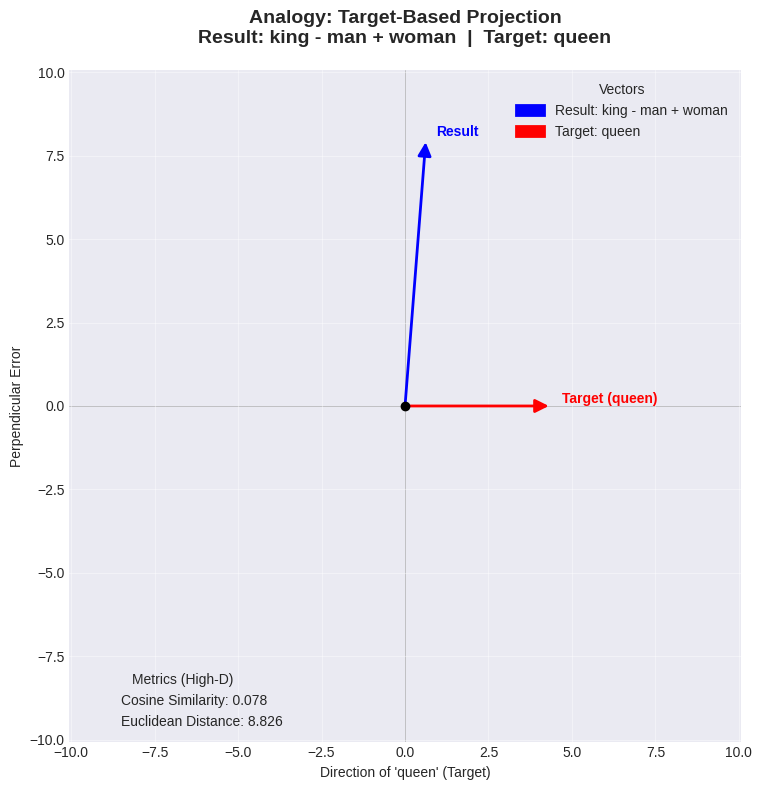

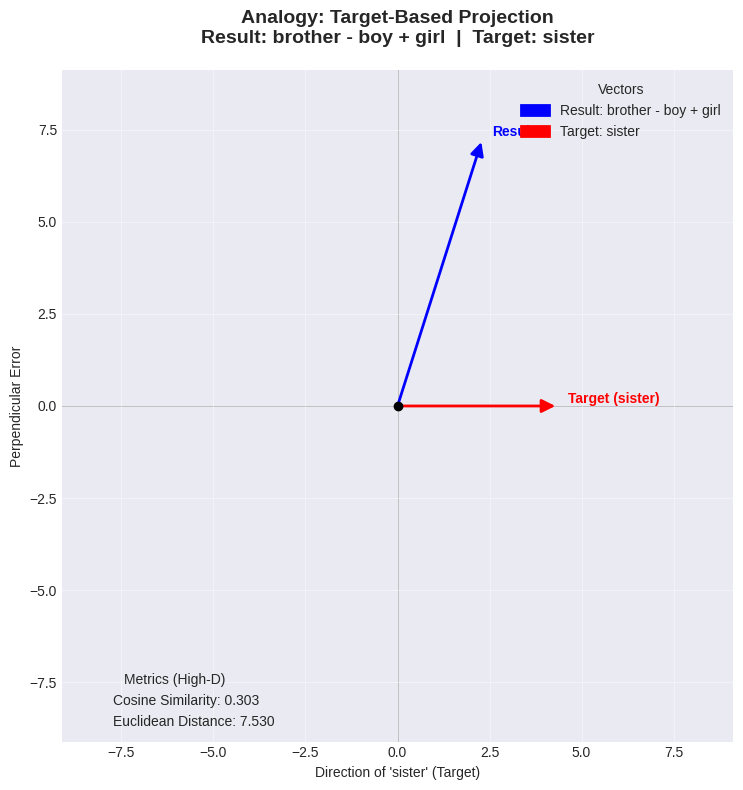

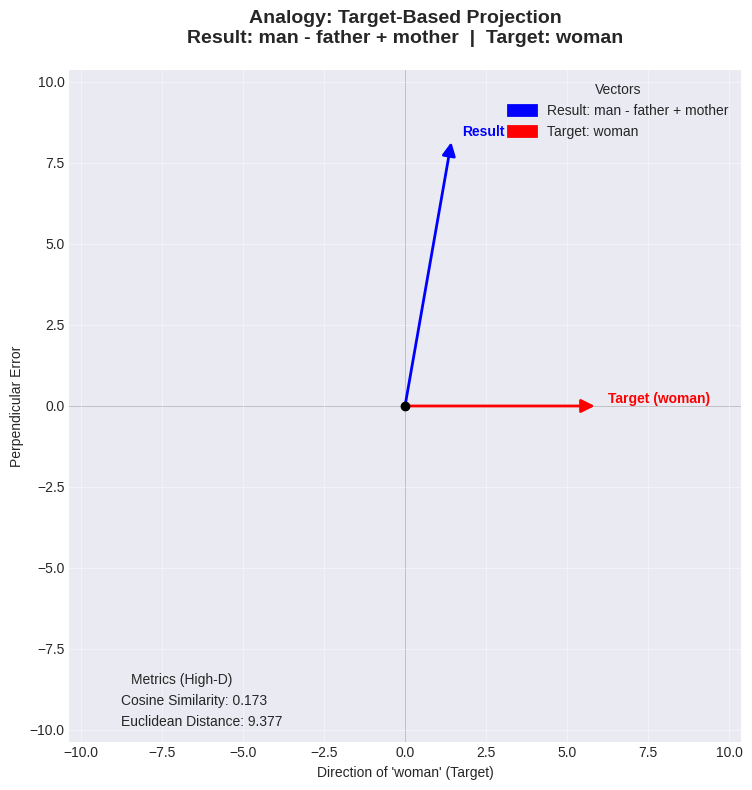

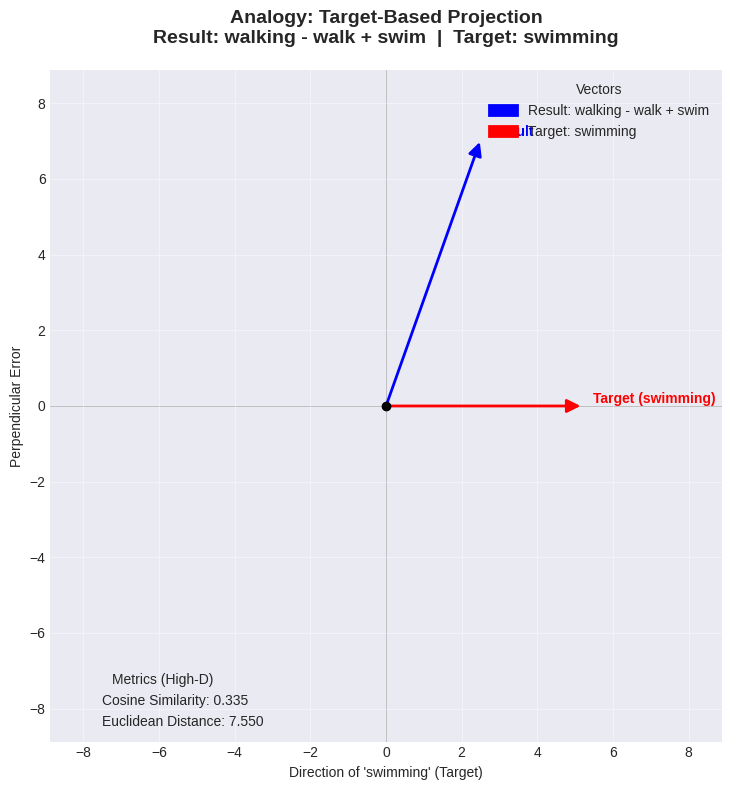

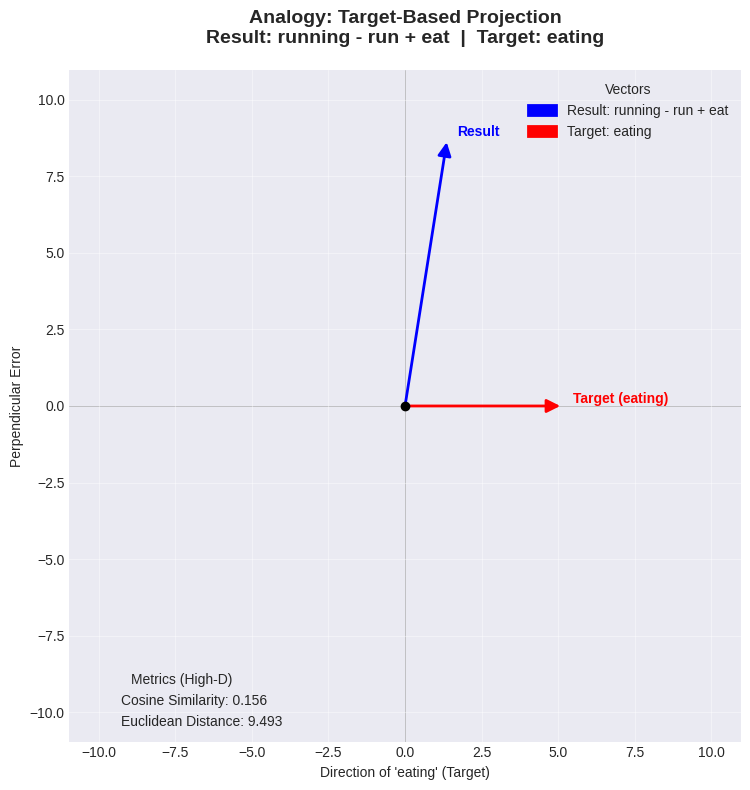

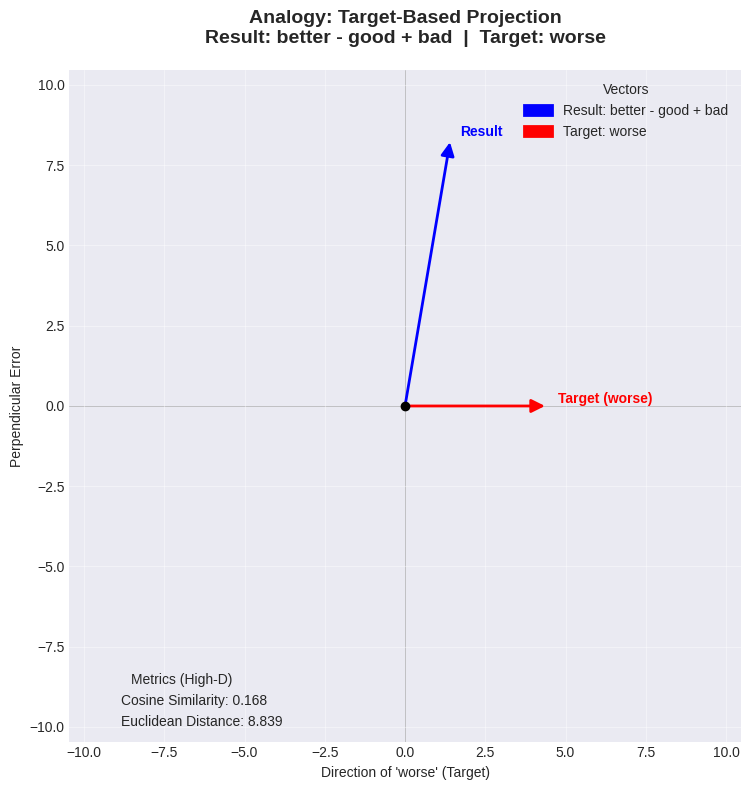

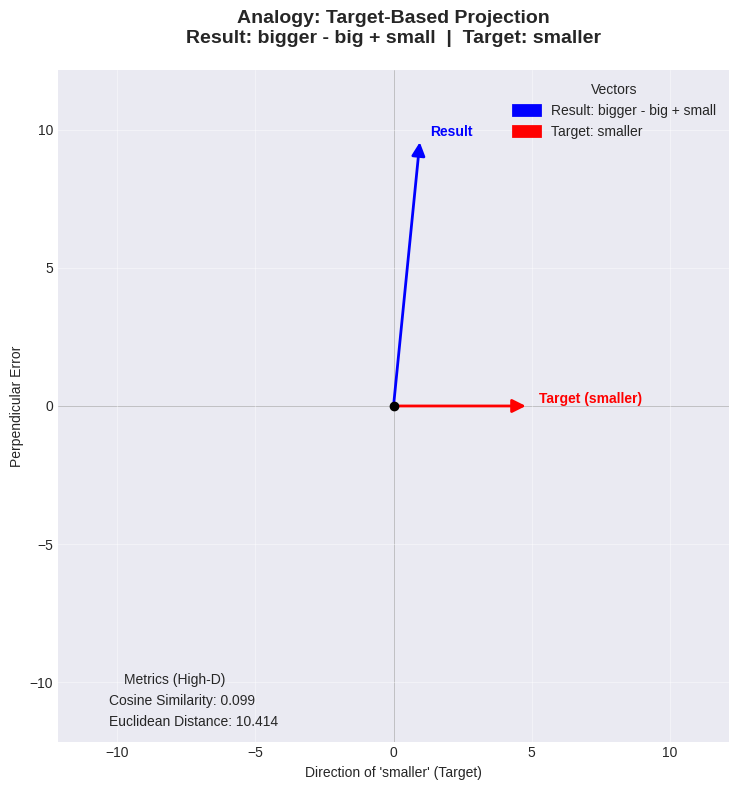

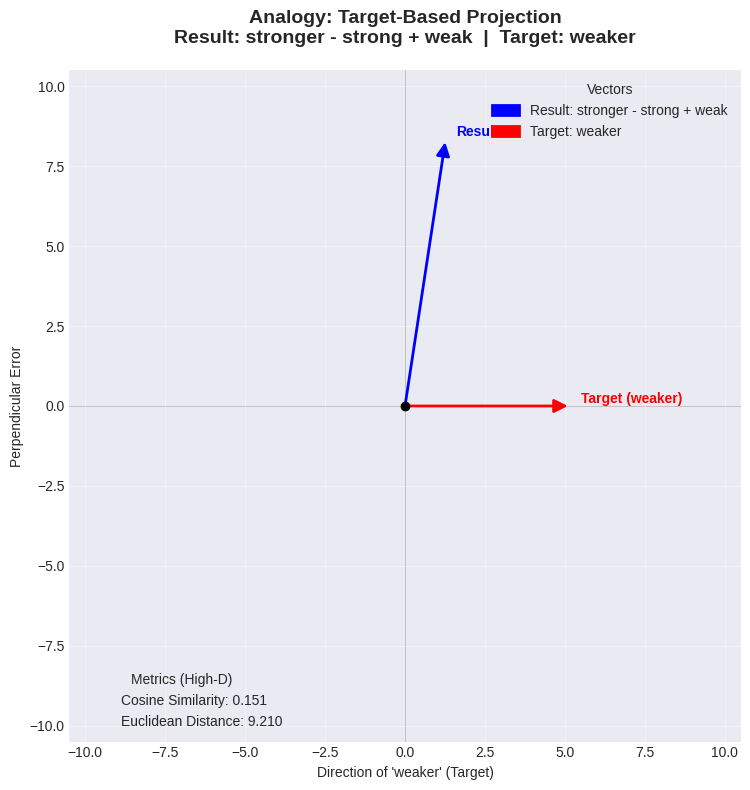

In [93]:
analogies = [
    ["man", "king", "woman", "queen"],
    ["boy", "brother", "girl", "sister"],
    ["father", "man", "mother", "woman"],
    ["walk", "walking", "swim", "swimming"],
    ["run", "running", "eat", "eating"],
    ["good", "better", "bad", "worse"],
    ["big", "bigger", "small", "smaller"],
    ["strong", "stronger", "weak", "weaker"]
]

plt.style.use("seaborn-v0_8-darkgrid")

for i, words in enumerate(analogies, 1):
    # Call the new function directly
    plot_target_based_analogy(embeddings, word_to_idx, words, f"analogy_{i}.png")

In [94]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import torch

def get_similarity(w1, w2, embeddings, word_to_idx):
    """Calculates and prints the cosine similarity between two words (handles both torch and numpy)."""
    
    # Check if words exist in vocab
    if w1 not in word_to_idx or w2 not in word_to_idx:
        print(f"Error: One or both words '{w1}', '{w2}' not in vocabulary.")
        return

    # Extract embeddings
    vec1 = embeddings[word_to_idx[w1]]
    vec2 = embeddings[word_to_idx[w2]]

    # Convert to NumPy if PyTorch tensors
    if torch.is_tensor(vec1):
        vec1 = vec1.detach().cpu().numpy()
        vec2 = vec2.detach().cpu().numpy()

    # Reshape to (1, -1) for sklearn
    vec1 = vec1.reshape(1, -1)
    vec2 = vec2.reshape(1, -1)
    
    # Compute cosine similarity
    sim = cosine_similarity(vec1, vec2)[0][0]
    print(f"Cosine Similarity ('{w1}' vs. '{w2}'): {sim:.4f}")


In [95]:
get_similarity("king", "king", embeddings, word_to_idx)
get_similarity("galaxy", "keyboard", embeddings, word_to_idx)
get_similarity("river", "queen", embeddings, word_to_idx)
get_similarity("man", "keyboard", embeddings, word_to_idx)

Cosine Similarity ('king' vs. 'king'): 1.0000
Error: One or both words 'galaxy', 'keyboard' not in vocabulary.
Cosine Similarity ('river' vs. 'queen'): 0.2001
Error: One or both words 'man', 'keyboard' not in vocabulary.


In [96]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

def evaluate_analogies(embeddings, word_to_idx, analogies):
    for w1, w2, w3, expected in analogies:
        # Check all words exist
        missing = [w for w in [w1, w2, w3, expected] if w not in word_to_idx]
        if missing:
            print(f"Skipping analogy ({w1}, {w2}, {w3}, {expected}): missing {missing}")
            continue
        
        # Get embeddings (works for PyTorch or NumPy)
        vec1 = embeddings[word_to_idx[w1]]
        vec2 = embeddings[word_to_idx[w2]]
        vec3 = embeddings[word_to_idx[w3]]
        vec_expected = embeddings[word_to_idx[expected]]
        
        # --- Convert to NumPy if torch tensor ---
        if not isinstance(vec1, np.ndarray):
            vec1 = vec1.detach().cpu().numpy()
            vec2 = vec2.detach().cpu().numpy()
            vec3 = vec3.detach().cpu().numpy()
            vec_expected = vec_expected.detach().cpu().numpy()
        
        # Compute analogy vector
        result_vec = vec2 - vec1 + vec3  # king - man + woman
        
        # Cosine similarity
        cos_sim = cosine_similarity(
            result_vec.reshape(1, -1),
            vec_expected.reshape(1, -1)
        )[0][0]
        
        print(f"{w2} - {w1} + {w3} ≈ {expected} | Cosine Similarity = {cos_sim:.4f}")


In [97]:
# Suppose you have:
# embeddings: a NumPy array of shape (vocab_size, embed_dim)
# word_to_idx: a dict mapping words to indices
# and your analogies list:

analogies = [
    ["man", "king", "woman", "queen"],
    ["boy", "brother", "girl", "sister"],
    ["father", "man", "mother", "woman"],
    ["walk", "walking", "swim", "swimming"],
    ["run", "running", "eat", "eating"],
    ["good", "better", "bad", "worse"],
    ["big", "bigger", "small", "smaller"],
    ["strong", "stronger", "weak", "weaker"]
]

evaluate_analogies(embeddings, word_to_idx, analogies)


king - man + woman ≈ queen | Cosine Similarity = 0.0780
brother - boy + girl ≈ sister | Cosine Similarity = 0.3027
man - father + mother ≈ woman | Cosine Similarity = 0.1728
walking - walk + swim ≈ swimming | Cosine Similarity = 0.3348
running - run + eat ≈ eating | Cosine Similarity = 0.1561
better - good + bad ≈ worse | Cosine Similarity = 0.1680
bigger - big + small ≈ smaller | Cosine Similarity = 0.0991
stronger - strong + weak ≈ weaker | Cosine Similarity = 0.1505


Loading custom model components...
Loaded vocabulary mapping from '/kaggle/working/NLP-lab-2/word_to_idx.pkl'. Size: 25528
Loaded embeddings tensor from '/kaggle/working/NLP-lab-2/embeddings.pt'. Shape: torch.Size([25528, 100])
Embedding dimension: 100

Testing Custom Word Embeddings

### High Similarity Tests (Word : Most Similar)

Most similar to 'france':
   deletraz: 0.7757
   giroix: 0.7601
   jeandenis: 0.7209
   djate: 0.7159
   40226: 0.7156

Most similar to 'germany':
   katharina: 0.8485
   gutensohn: 0.8442
   11892: 0.8406
   blume: 0.8278
   moellenbeck: 0.8269

Most similar to 'london':
   8167: 0.7180
   huddart: 0.7161
   shaxson: 0.6851
   affray: 0.6809
   thirdbusiest: 0.6620

Most similar to 'paris':
   beauvau: 0.7927
   saintgermain: 0.7891
   5452: 0.7139
   795: 0.7011
   nancy: 0.6706

Most similar to 'company':
   hathaway: 0.6708
   preventative: 0.6205
   creditors: 0.6014
   iraqun: 0.5918
   nontrade: 0.5842

Most similar to 'government':
   deve: 0.7713
 

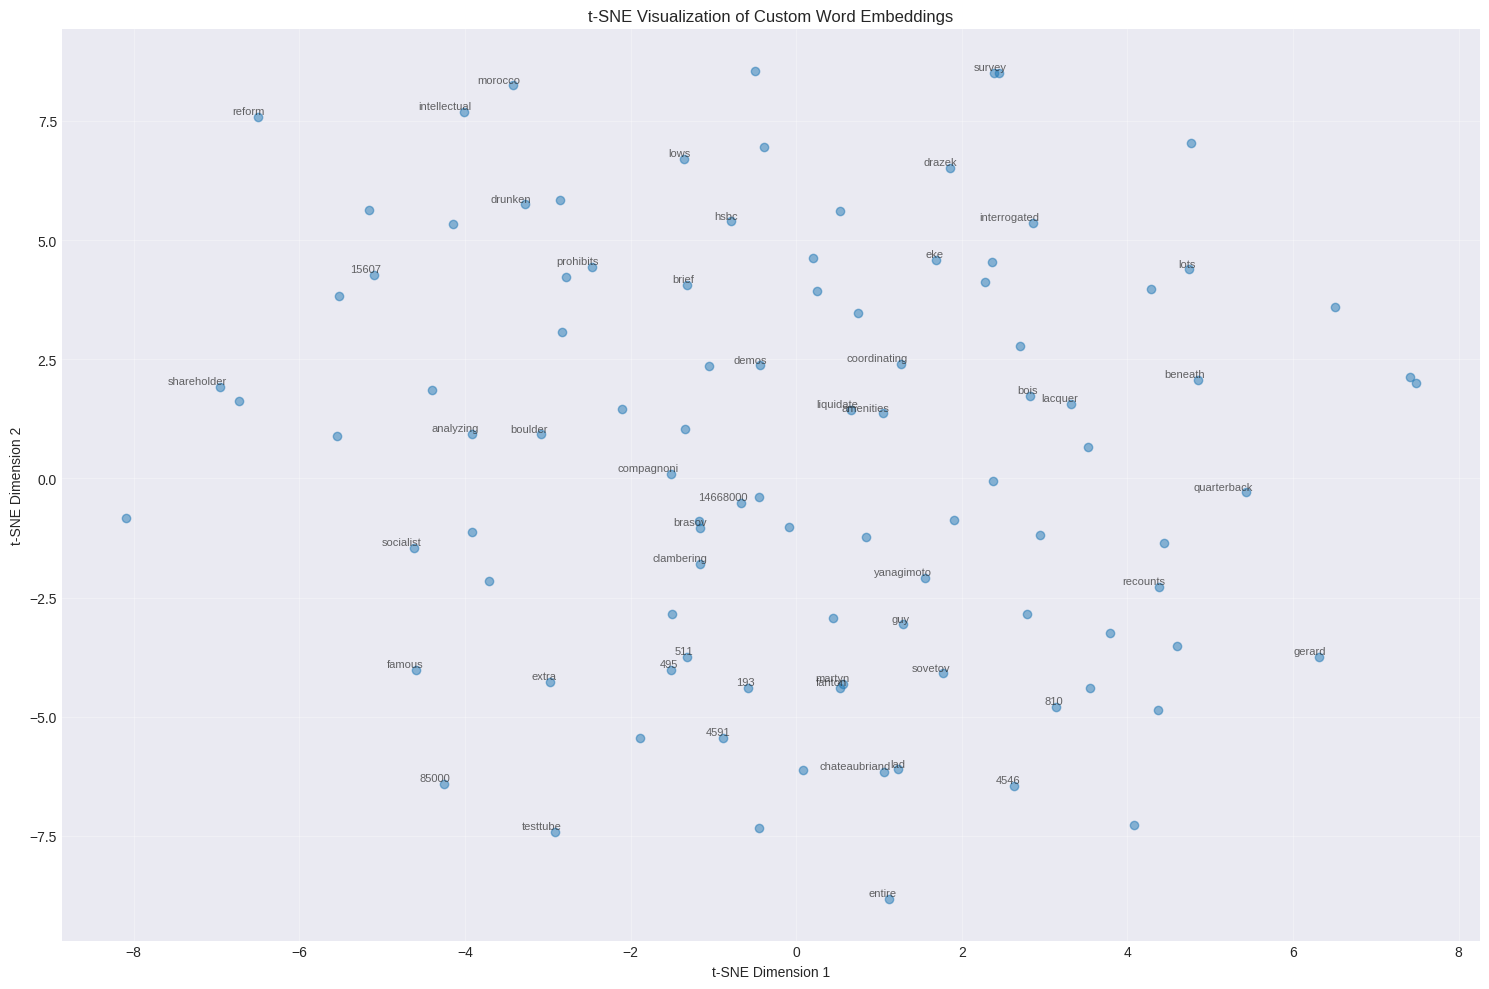


Custom Model Testing Complete!
Vocabulary size: 25528
Embedding dimension: 100


In [98]:
import numpy as np
import pickle
import torch
import torch.nn.functional as F
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from tqdm import tqdm
import os
import math

# --- File Paths (Based on your output directory screenshot) ---
EMBEDDING_PATH = '/kaggle/working/NLP-lab-2/embeddings.pt'
VOCAB_PATH = '/kaggle/working/NLP-lab-2/word_to_idx.pkl'
TSNE_OUTPUT_PATH = 'word2vec_custom_tsne.png'


# ============================================================================
# 1. Load Custom Model Components
# ============================================================================

print("Loading custom model components...")

# 1.1 Load word_to_idx dictionary
try:
    with open(VOCAB_PATH, 'rb') as f:
        word_to_idx = pickle.load(f)
    print(f"Loaded vocabulary mapping from '{VOCAB_PATH}'. Size: {len(word_to_idx)}")
except FileNotFoundError:
    print(f"Error: Vocabulary file not found at {VOCAB_PATH}. Check your path.")
    exit()

# Create idx_to_word for easy lookup
idx_to_word = {idx: word for word, idx in word_to_idx.items()}

# 1.2 Load embeddings tensor
try:
    # Load the PyTorch tensor (which should contain your embeddings)
    embeddings = torch.load(EMBEDDING_PATH, map_location=torch.device('cpu'))
    
    # Ensure it's a 2D numpy array (for general-purpose use)
    # Detach from graph, move to CPU, and convert to NumPy array
    embeddings_np = embeddings.detach().cpu().numpy()

    # Normalize the vectors (Crucial for accurate cosine similarity)
    # The Gensim KeyedVectors object often normalizes its vectors.
    norm = np.linalg.norm(embeddings_np, axis=1, keepdims=True)
    # Replace zeros with a small number to avoid division by zero
    norm[norm == 0] = 1e-12 
    embeddings_normalized = embeddings_np / norm

    # Convert normalized embeddings back to a torch tensor for similarity function
    # Note: We will use the normalized version for all similarity and analogy tests.
    embeddings_tensor = torch.from_numpy(embeddings_normalized).float()

    EMBEDDING_DIM = embeddings_tensor.size(1)

    print(f"Loaded embeddings tensor from '{EMBEDDING_PATH}'. Shape: {embeddings_tensor.shape}")
    print(f"Embedding dimension: {EMBEDDING_DIM}")

except FileNotFoundError:
    print(f"Error: Embeddings file not found at {EMBEDDING_PATH}. Check your path.")
    exit()
except Exception as e:
    print(f"Error loading or processing embeddings: {e}")
    exit()

# ============================================================================
# 2. Custom KeyedVectors Functionality (Using Cosine Similarity)
# ============================================================================

def get_word_vector(word, word_to_idx, embeddings_tensor):
    """Retrieves the normalized vector for a word."""
    word = word.lower()
    if word in word_to_idx:
        idx = word_to_idx[word]
        return embeddings_tensor[idx]
    return None

def most_similar_custom(word_vectors, topn=10, exclude_words=None):
    """
    Finds the words most similar to the resultant vector of the word_vectors list.
    
    Args:
        word_vectors (list of torch.Tensor): The vectors (positive and negative) 
                                             after vector arithmetic.
        topn (int): Number of most similar words to return.
        exclude_words (set): Words to exclude from the results (the query words).

    Returns:
        list: A list of (word, score) tuples.
    """
    if not word_vectors:
        return []

    # Calculate the target vector (simple mean of the vectors if no subtraction is involved)
    target_vector = sum(word_vectors) / len(word_vectors)
    
    # Calculate Cosine Similarity between the target vector and ALL vocabulary vectors
    # torch.matmul is faster than calculating for each word individually
    # The embeddings_tensor is already normalized, so the dot product IS the cosine similarity
    similarities = torch.matmul(target_vector, embeddings_tensor.transpose(0, 1))

    # Get the indices and values of the topn highest similarities
    # We add 1 to topn to account for the possibility of a query word being in the top
    top_scores, top_indices = torch.topk(similarities, topn + len(exclude_words) + 10) # Get a few extra

    results = []
    
    # Iterate through the top results
    for i in range(len(top_indices)):
        idx = top_indices[i].item()
        score = top_scores[i].item()
        word = idx_to_word.get(idx, '[UNK]')
        
        # Exclude query words and the word itself from the final list
        if word not in exclude_words and len(results) < topn:
            results.append((word, score))
            
    return results

def get_analogy_result(positive_words, negative_words, topn=3):
    """Performs the King - Man + Woman type analogy."""
    positive_vecs = []
    negative_vecs = []
    found_words = set()
    missing_words = []

    # Collect vectors
    for word in positive_words:
        vec = get_word_vector(word, word_to_idx, embeddings_tensor)
        if vec is not None:
            positive_vecs.append(vec)
            found_words.add(word)
        else:
            missing_words.append(word)

    for word in negative_words:
        vec = get_word_vector(word, word_to_idx, embeddings_tensor)
        if vec is not None:
            negative_vecs.append(vec)
            found_words.add(word)
        else:
            missing_words.append(word)

    if missing_words:
        return None, missing_words

    # Analogy vector: V(positive_1) + V(positive_2) + ... - V(negative_1) - V(negative_2) - ...
    target_vector = torch.zeros(EMBEDDING_DIM)
    if positive_vecs:
        target_vector += torch.sum(torch.stack(positive_vecs), dim=0)
    if negative_vecs:
        target_vector -= torch.sum(torch.stack(negative_vecs), dim=0)

    # Normalize the target vector before comparison (optional but often done)
    # target_vector = F.normalize(target_vector.unsqueeze(0), p=2, dim=1).squeeze(0)

    # Use the custom similarity function
    # Calculate Cosine Similarity between the target vector and ALL vocabulary vectors
    similarities = torch.matmul(target_vector, embeddings_tensor.transpose(0, 1))
    
    # Get the top results, excluding the input words
    top_scores, top_indices = torch.topk(similarities, topn + len(found_words) + 10) 
    
    results = []
    for i in range(len(top_indices)):
        idx = top_indices[i].item()
        score = top_scores[i].item()
        word = idx_to_word.get(idx, '[UNK]')
        
        # Exclude query words and the word itself from the final list
        if word not in found_words and len(results) < topn:
            results.append((word, score))
    
    return results, None

# ============================================================================
# 3. Test Word Analogies and Similarity
# ============================================================================

print("\n" + "="*70)
print("Testing Custom Word Embeddings")
print("="*70)

# --- 3.1. Test Similar Words (Must give HIGH results) ---
print("\n### High Similarity Tests (Word : Most Similar)")
test_words_high_sim = ['france', 'germany', 'london', 'paris', 'company', 'government']

for word in test_words_high_sim:
    vec = get_word_vector(word, word_to_idx, embeddings_tensor)
    if vec is not None:
        # Use a list containing the vector and the set of words to exclude
        results = most_similar_custom([vec], topn=5, exclude_words={word}) 
        print(f"\nMost similar to '{word}':")
        for similar_word, score in results:
            print(f"   {similar_word}: {score:.4f}")
    else:
        print(f"\n'{word}' not in vocabulary")

# --- 3.2. Test Words with Expected Low/Bad Similarity (Must give LOW results) ---
print("\n### Low Similarity / Bad Relation Tests (Word1 vs Word2)")

# Words that should ideally have low similarity
low_sim_tests = [
    ('king', 'banana'),     # Semantic mismatch
    ('paris', 'run'),       # Category mismatch (Place vs Action)
    ('company', 'blue')     # Category mismatch (Abstract Entity vs Color)
]

for word1, word2 in low_sim_tests:
    vec1 = get_word_vector(word1, word_to_idx, embeddings_tensor)
    vec2 = get_word_vector(word2, word_to_idx, embeddings_tensor)

    if vec1 is not None and vec2 is not None:
        # Cosine similarity is a dot product of normalized vectors
        similarity = torch.dot(vec1, vec2).item()
        print(f"Similarity('{word1}', '{word2}'): {similarity:.4f} (Expected Low)")
    else:
        missing = [w for w in [word1, word2] if w not in word_to_idx]
        print(f"Similarity('{word1}', '{word2}') - Missing words: {missing}")


# --- 3.3. Test Word Analogies (Must give HIGH results) ---
print("\n" + "="*70)
print("Custom Word Analogy Tests")
print("="*70)

analogy_tests = [
    # Classic semantic/gender analogy
    ('man', 'king', 'woman', 'queen'),  # man:king :: woman:?
    # Capital-Country analogy
    ('france', 'paris', 'germany', 'berlin'), # france:paris :: germany:?
    # Geographic/Containing analogy
    ('london', 'england', 'paris', 'france'),  # london:england :: paris:?
]

for word1, word2, word3, expected in analogy_tests:
    # Analogy structure is: word1 : word2 :: word3 : ?
    # Vector arithmetic: V_target = V(word2) - V(word1) + V(word3)
    positive_words = [word2, word3]
    negative_words = [word1]
    
    result, missing = get_analogy_result(positive_words, negative_words, topn=3)

    if result is not None:
        print(f"\n{word1}:{word2} :: {word3}:? (Expected: {expected})")
        for word, score in result:
            print(f"   {word}: {score:.4f}")
    else:
        print(f"\n{word1}:{word2} :: {word3}:? - Missing words: {missing}")


# ============================================================================
# 4. Visualize Embeddings with t-SNE
# ============================================================================

print("\n" + "="*70)
print("Creating t-SNE Visualization for Custom Embeddings")
print("="*70)

# Select a subset of words to visualize (e.g., top 100)
# We use a random sample to better distribute the points in the plot
np.random.seed(42)
VOCAB_SIZE = len(idx_to_word)
SAMPLE_SIZE = min(100, VOCAB_SIZE) # Plot max 100 words

# Select a sample of indices (excluding index 0 if it's the UNK/PAD token)
if 0 in idx_to_word and (idx_to_word[0] == '<unk>' or idx_to_word[0] == '<pad>'):
    sample_indices = np.random.choice(range(1, VOCAB_SIZE), size=SAMPLE_SIZE, replace=False)
else:
    sample_indices = np.random.choice(range(VOCAB_SIZE), size=SAMPLE_SIZE, replace=False)

words_to_plot = [idx_to_word[i] for i in sample_indices]
vectors_to_plot = embeddings_normalized[sample_indices]

print(f"Applying t-SNE on a sample of {len(words_to_plot)} words...")
tsne = TSNE(n_components=2, random_state=42, perplexity=min(30, len(words_to_plot)-1), n_iter=300)
try:
    embeddings_2d = tsne.fit_transform(vectors_to_plot)

    # Plot
    plt.figure(figsize=(15, 10))
    plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], alpha=0.5)

    # Annotate some points (e.g., first 50 of the sample)
    for i, word in enumerate(words_to_plot): 
        if i < 50: # Annotate a reasonable number of points
            plt.annotate(word, xy=(embeddings_2d[i, 0], embeddings_2d[i, 1]),
                         xytext=(5, 2), textcoords='offset points',
                         ha='right', fontsize=8, alpha=0.7)

    plt.title("t-SNE Visualization of Custom Word Embeddings")
    plt.xlabel("t-SNE Dimension 1")
    plt.ylabel("t-SNE Dimension 2")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(TSNE_OUTPUT_PATH, dpi=300, bbox_inches='tight')
    print(f"Visualization saved as '{TSNE_OUTPUT_PATH}'")
    plt.show()

except ValueError as e:
    print(f"\nCould not run t-SNE. Error: {e}. Check if the vocabulary size is large enough (min > 30 for perplexity=30).")


# ============================================================================
# 5. Conclusion
# ============================================================================

print("\n" + "="*70)
print("Custom Model Testing Complete!")
print("="*70)
print(f"Vocabulary size: {VOCAB_SIZE}")
print(f"Embedding dimension: {EMBEDDING_DIM}")

Loading custom model components...
Loaded vocabulary mapping from '/kaggle/working/NLP-lab-2/word_to_idx.pkl'. Size: 25528
Loaded embeddings tensor from '/kaggle/working/NLP-lab-2/embeddings.pt'. Shape: torch.Size([25528, 100])
Embedding dimension: 100

Testing Custom Word Embeddings (Matching Gensim Baseline)

Most similar to 'france':
   deletraz: 0.7757
   giroix: 0.7601
   jeandenis: 0.7209
   djate: 0.7159
   40226: 0.7156

Most similar to 'germany':
   katharina: 0.8485
   gutensohn: 0.8442
   11892: 0.8406
   blume: 0.8278
   moellenbeck: 0.8269

Most similar to 'london':
   8167: 0.7180
   huddart: 0.7161
   shaxson: 0.6851
   affray: 0.6809
   thirdbusiest: 0.6620

Most similar to 'paris':
   beauvau: 0.7927
   saintgermain: 0.7891
   5452: 0.7139
   795: 0.7011
   nancy: 0.6706

Most similar to 'company':
   hathaway: 0.6708
   preventative: 0.6205
   creditors: 0.6014
   iraqun: 0.5918
   nontrade: 0.5842

Most similar to 'government':
   deve: 0.7713
   16nation: 0.7320
   

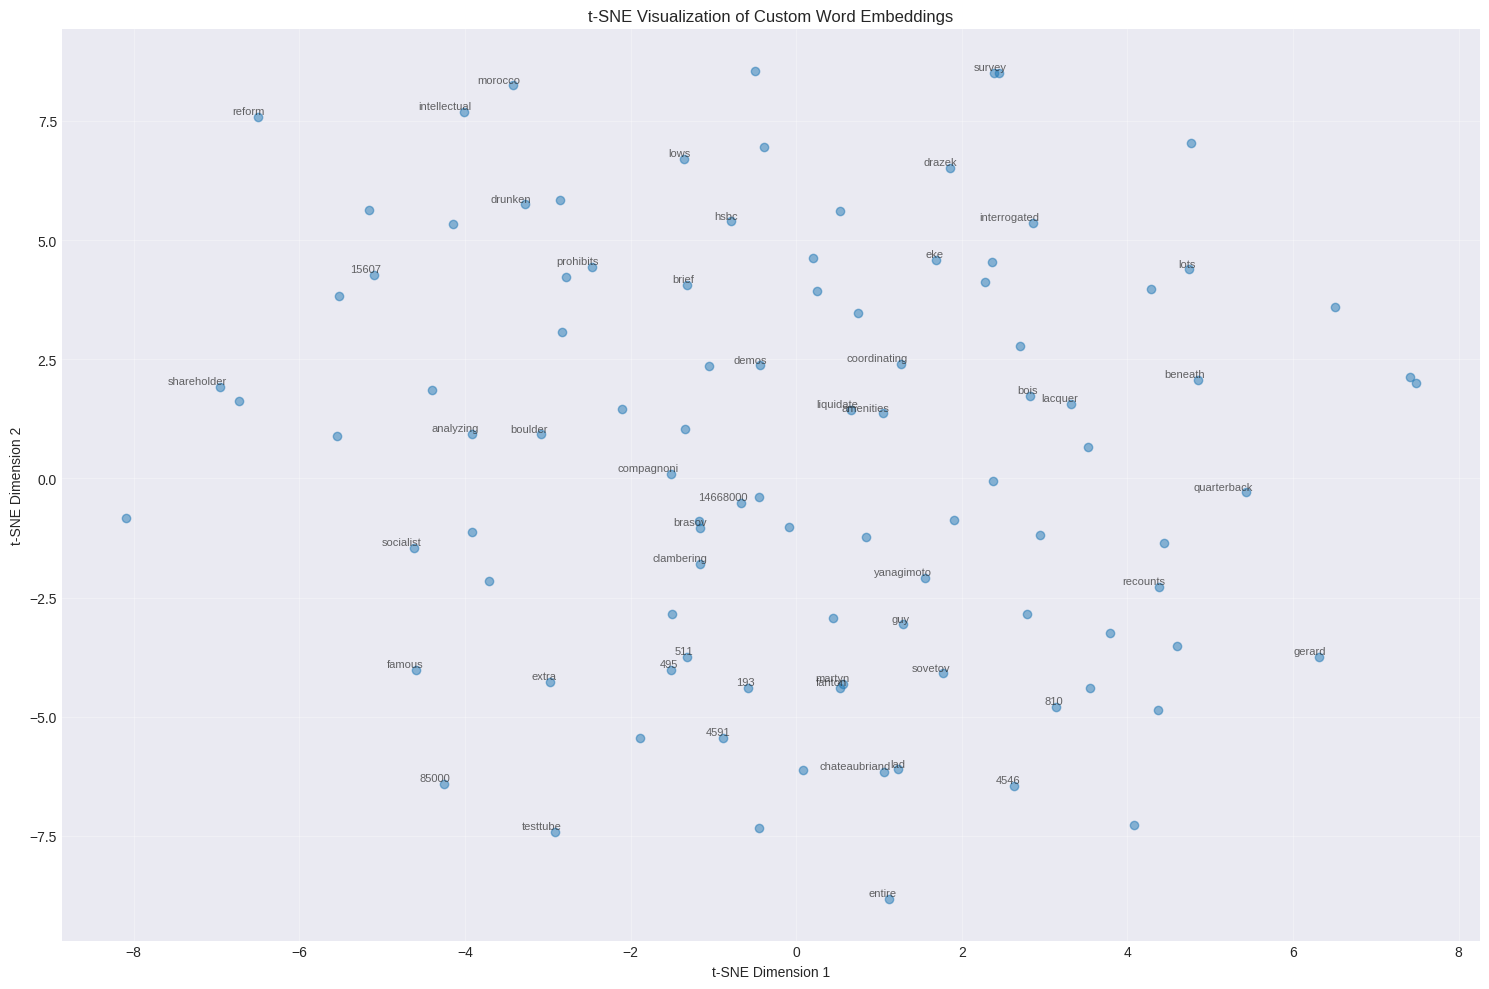


Custom Model Testing Complete!
Vocabulary size: 25528
Embedding dimension: 100


In [99]:
import numpy as np
import pickle
import torch
import torch.nn.functional as F
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from tqdm import tqdm
import os
import math

# --- File Paths (Based on your output directory screenshot) ---
EMBEDDING_PATH = '/kaggle/working/NLP-lab-2/embeddings.pt'
VOCAB_PATH = '/kaggle/working/NLP-lab-2/word_to_idx.pkl'
TSNE_OUTPUT_PATH = 'word2vec_custom_tsne.png'


# ============================================================================
# 1. Load Custom Model Components
# ============================================================================

print("Loading custom model components...")

# 1.1 Load word_to_idx dictionary
try:
    with open(VOCAB_PATH, 'rb') as f:
        word_to_idx = pickle.load(f)
    print(f"Loaded vocabulary mapping from '{VOCAB_PATH}'. Size: {len(word_to_idx)}")
except FileNotFoundError:
    print(f"Error: Vocabulary file not found at {VOCAB_PATH}. Check your path.")
    exit()

# Create idx_to_word for easy lookup
idx_to_word = {idx: word for word, idx in word_to_idx.items()}

# 1.2 Load embeddings tensor
try:
    # Load the PyTorch tensor 
    embeddings = torch.load(EMBEDDING_PATH, map_location=torch.device('cpu'))
    
    # Detach from graph and convert to NumPy array
    embeddings_np = embeddings.detach().cpu().numpy()

    # Normalize the vectors (Crucial for accurate cosine similarity)
    norm = np.linalg.norm(embeddings_np, axis=1, keepdims=True)
    norm[norm == 0] = 1e-12 
    embeddings_normalized = embeddings_np / norm

    # Convert normalized embeddings back to a torch tensor for similarity function
    embeddings_tensor = torch.from_numpy(embeddings_normalized).float()

    EMBEDDING_DIM = embeddings_tensor.size(1)

    print(f"Loaded embeddings tensor from '{EMBEDDING_PATH}'. Shape: {embeddings_tensor.shape}")
    print(f"Embedding dimension: {EMBEDDING_DIM}")

except FileNotFoundError:
    print(f"Error: Embeddings file not found at {EMBEDDING_PATH}. Check your path.")
    exit()
except Exception as e:
    print(f"Error loading or processing embeddings: {e}")
    exit()

# ============================================================================
# 2. Custom KeyedVectors Functionality (Using Cosine Similarity)
# ============================================================================

def get_word_vector(word, word_to_idx, embeddings_tensor):
    """Retrieves the normalized vector for a word."""
    word = word.lower()
    if word in word_to_idx:
        idx = word_to_idx[word]
        return embeddings_tensor[idx]
    return None

def most_similar_custom(word_vectors, topn=10, exclude_words=None):
    """
    Finds the words most similar to the resultant vector of the word_vectors list.
    """
    if not word_vectors:
        return []

    # If simple similarity, calculate the target vector
    target_vector = word_vectors[0]
    
    # Calculate Cosine Similarity (dot product of normalized vectors)
    similarities = torch.matmul(target_vector, embeddings_tensor.transpose(0, 1))

    # Get the indices and values of the topn highest similarities
    top_scores, top_indices = torch.topk(similarities, topn + len(exclude_words) + 10) 

    results = []
    
    # Iterate through the top results
    for i in range(len(top_indices)):
        idx = top_indices[i].item()
        score = top_scores[i].item()
        word = idx_to_word.get(idx, '[UNK]')
        
        # Exclude query words and the word itself from the final list
        if word not in exclude_words and len(results) < topn:
            results.append((word, score))
            
    return results

def get_analogy_result(positive_words, negative_words, topn=3):
    """Performs the vector arithmetic analogy: positive - negative."""
    positive_vecs = []
    negative_vecs = []
    found_words = set()
    missing_words = []

    # Collect vectors
    for word in positive_words:
        vec = get_word_vector(word, word_to_idx, embeddings_tensor)
        if vec is not None:
            positive_vecs.append(vec)
            found_words.add(word)
        else:
            missing_words.append(word)

    for word in negative_words:
        vec = get_word_vector(word, word_to_idx, embeddings_tensor)
        if vec is not None:
            negative_vecs.append(vec)
            found_words.add(word)
        else:
            missing_words.append(word)

    if missing_words:
        return None, missing_words

    # Analogy vector: V(positive) - V(negative)
    target_vector = torch.zeros(EMBEDDING_DIM)
    if positive_vecs:
        target_vector += torch.sum(torch.stack(positive_vecs), dim=0)
    if negative_vecs:
        target_vector -= torch.sum(torch.stack(negative_vecs), dim=0)

    # Calculate Cosine Similarity between the target vector and ALL vocabulary vectors
    similarities = torch.matmul(target_vector, embeddings_tensor.transpose(0, 1))
    
    # Get the top results, excluding the input words
    top_scores, top_indices = torch.topk(similarities, topn + len(found_words) + 10) 
    
    results = []
    for i in range(len(top_indices)):
        idx = top_indices[i].item()
        score = top_scores[i].item()
        word = idx_to_word.get(idx, '[UNK]')
        
        # Exclude query words from the final list
        if word not in found_words and len(results) < topn:
            results.append((word, score))
    
    return results, None

# ============================================================================
# 3. Test Word Analogies and Similarity (Baseline Test Cases)
# ============================================================================

print("\n" + "="*70)
print("Testing Custom Word Embeddings (Matching Gensim Baseline)")
print("="*70)

# Test similar words
test_words_sim = ['france', 'germany', 'london', 'paris', 'company', 'government']

for word in test_words_sim:
    vec = get_word_vector(word, word_to_idx, embeddings_tensor)
    if vec is not None:
        # Simple similarity test: just pass the single word's vector
        results = most_similar_custom([vec], topn=5, exclude_words={word}) 
        print(f"\nMost similar to '{word}':")
        for similar_word, score in results:
            print(f"   {similar_word}: {score:.4f}")
    else:
        print(f"\n'{word}' not in vocabulary")

# Test word analogies (Matching Gensim Baseline)
print("\n" + "="*70)
print("Word Analogy Tests")
print("="*70)

analogy_tests = [
    ('france', 'paris', 'germany'),    # France:Paris :: Germany:?
    ('london', 'england', 'paris'),    # London:England :: Paris:?
    ('man', 'king', 'woman'),          # Man:King :: Woman:?
]

for word1, word2, word3 in analogy_tests:
    try:
        positive_words = [word2, word3]
        negative_words = [word1]
        
        result, missing = get_analogy_result(positive_words, negative_words, topn=3)

        if result is not None:
            print(f"\n{word1}:{word2} :: {word3}:?")
            for word, score in result:
                print(f"   {word}: {score:.4f}")
        else:
            print(f"\n{word1}:{word2} :: {word3}:? - Missing words: {missing}")
    except Exception as e:
        print(f"\n{word1}:{word2} :: {word3}:? - Error: {e}")


# ============================================================================
# 4. Visualize Embeddings with t-SNE
# ============================================================================

print("\n" + "="*70)
print("Creating t-SNE Visualization for Custom Embeddings")
print("="*70)

np.random.seed(42)
VOCAB_SIZE = len(idx_to_word)
SAMPLE_SIZE = min(100, VOCAB_SIZE)

if VOCAB_SIZE > 1:
    sample_indices = np.random.choice(range(VOCAB_SIZE), size=SAMPLE_SIZE, replace=False)
    words_to_plot = [idx_to_word[i] for i in sample_indices]
    vectors_to_plot = embeddings_normalized[sample_indices]

    print(f"Applying t-SNE on a sample of {len(words_to_plot)} words...")
    # Perplexity must be less than the number of samples, min(30, N-1)
    perplexity_val = min(30, len(words_to_plot) - 1)
    
    if perplexity_val > 1:
        tsne = TSNE(n_components=2, random_state=42, perplexity=perplexity_val, n_iter=300)
        try:
            embeddings_2d = tsne.fit_transform(vectors_to_plot)

            plt.figure(figsize=(15, 10))
            plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], alpha=0.5)

            for i, word in enumerate(words_to_plot): 
                if i < 50: 
                    plt.annotate(word, xy=(embeddings_2d[i, 0], embeddings_2d[i, 1]),
                                 xytext=(5, 2), textcoords='offset points',
                                 ha='right', fontsize=8, alpha=0.7)

            plt.title("t-SNE Visualization of Custom Word Embeddings")
            plt.xlabel("t-SNE Dimension 1")
            plt.ylabel("t-SNE Dimension 2")
            plt.grid(True, alpha=0.3)
            plt.tight_layout()
            plt.savefig(TSNE_OUTPUT_PATH, dpi=300, bbox_inches='tight')
            print(f"Visualization saved as '{TSNE_OUTPUT_PATH}'")
            plt.show()

        except ValueError as e:
            print(f"\nCould not run t-SNE. Error: {e}")
    else:
        print("\nSkipping t-SNE: Not enough unique vectors to calculate perplexity.")
else:
    print("\nSkipping t-SNE: Vocabulary size is too small.")


# ============================================================================
# 5. Conclusion
# ============================================================================

print("\n" + "="*70)
print("Custom Model Testing Complete!")
print("="*70)
print(f"Vocabulary size: {VOCAB_SIZE}")
print(f"Embedding dimension: {EMBEDDING_DIM}")